Веса модели выравнивания успешно загружены.
Веса модели эмбеддингов успешно загружены.
Один и тот же ли это человек?: False
Сходство: 0.2904


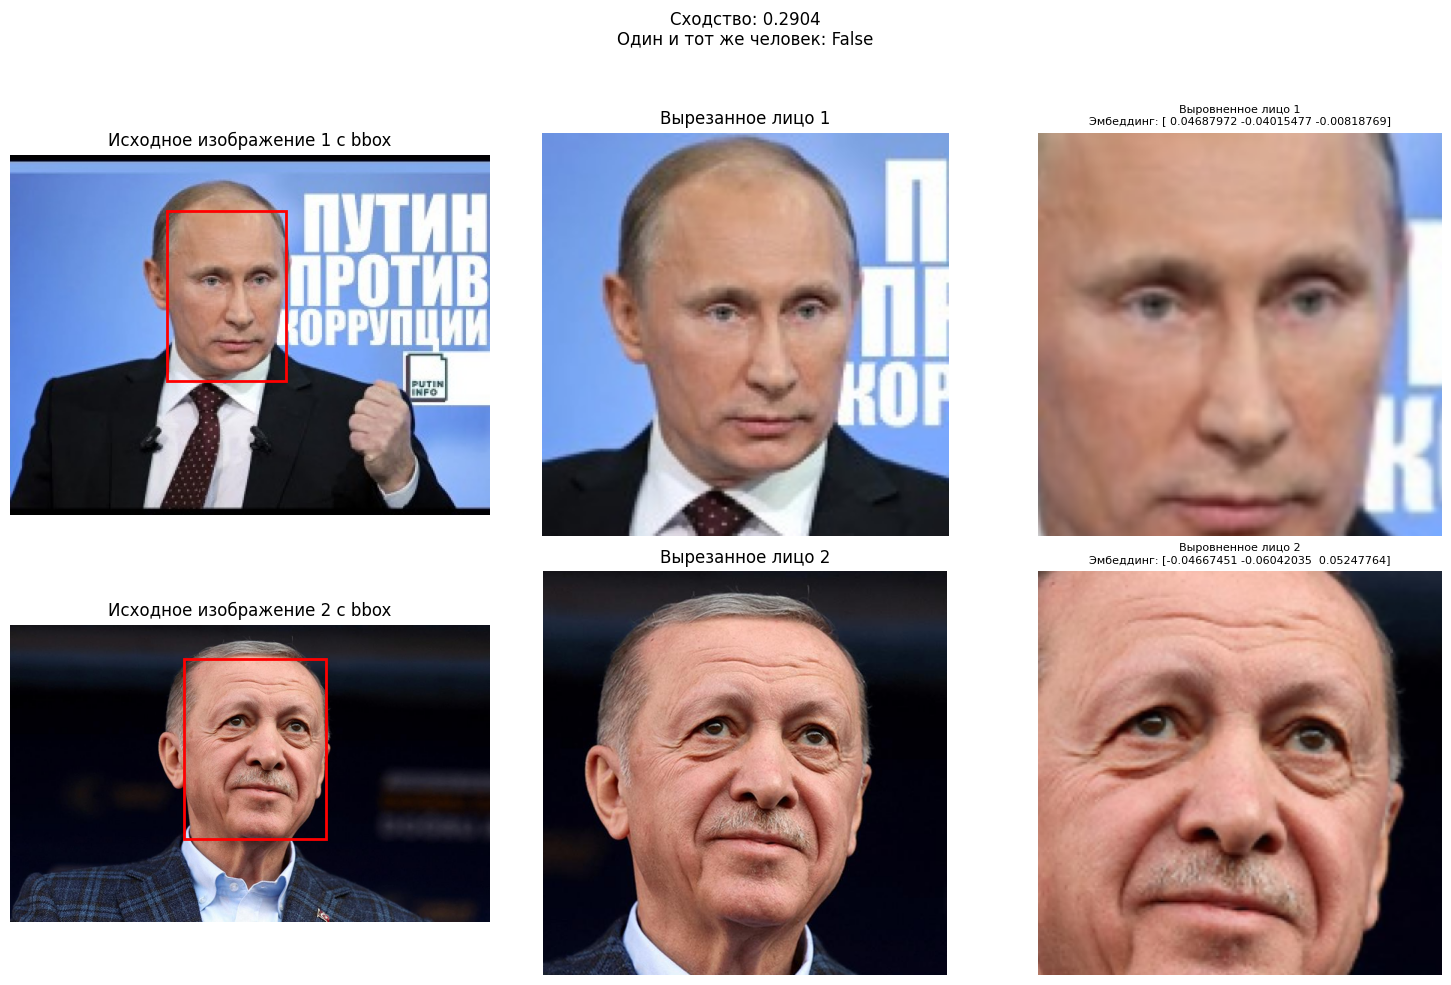

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from facenet_pytorch import MTCNN
from PIL import Image
import pandas as pd
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import math
import torchvision.models as models
import matplotlib.pyplot as plt

# ---- Блок для модели с нахождением точек и выравниванием ----
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

class Hourglass(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.enc1 = ResidualBlock(channels, channels)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc2 = ResidualBlock(channels, channels)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.enc3 = ResidualBlock(channels, channels)
        self.enc4 = ResidualBlock(channels, channels)
        self.de1 = ResidualBlock(channels, channels)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.de2 = ResidualBlock(channels, channels)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.de3 = ResidualBlock(channels, channels)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.de4 = ResidualBlock(channels, channels)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(e3)
        d1 = self.de1(self.upsample1(e4))
        d1 = F.interpolate(d1, size=e3.shape[2:], mode='bilinear', align_corners=False) + e3
        d2 = self.de2(self.upsample2(d1))
        d2 = F.interpolate(d2, size=e2.shape[2:], mode='bilinear', align_corners=False) + e2
        d3 = self.de3(self.upsample3(d2))
        d3 = F.interpolate(d3, size=e1.shape[2:], mode='bilinear', align_corners=False) + e1
        d4 = self.de4(d3)
        return d4

class StackedHN(nn.Module):
    def __init__(self, in_channels=3, out_channels=5):
        super().__init__()
        self.init_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2, 2),
            ResidualBlock(128, 128),
            ResidualBlock(128, 256)
        )
        self.hg1 = Hourglass(256)
        self.hg2 = Hourglass(256)
        self.out_conv1 = nn.Conv2d(256, out_channels, kernel_size=1)
        self.out_conv2 = nn.Conv2d(256, out_channels, kernel_size=1)
        self.merge1 = nn.Sequential(
            nn.Conv2d(out_channels, 256, kernel_size=1),
            ResidualBlock(256, 256)
        )

    def forward(self, x):
        x = self.init_conv(x)
        hg1_out = self.hg1(x)
        out1 = self.out_conv1(hg1_out)
        merged2 = self.merge1(out1) + hg1_out
        hg2_out = self.hg2(merged2)
        out2 = self.out_conv2(hg2_out)
        return out1, out2
    
# ---- Блок для модели с ArcFace ----
class ArcFaceLayer(nn.Module):
    def __init__(self, in_features, out_features, s=15.0, m=0.3):
        super(ArcFaceLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, embedding, label):
        embedding_norm = F.normalize(embedding)
        weight_norm = F.normalize(self.weight)
        cosine = F.linear(embedding_norm, weight_norm)
        one_hot = torch.zeros(cosine.size(), device=embedding.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        cos_theta_yi = torch.gather(cosine, 1, label.view(-1, 1).long()).view(-1)
        cos_theta_yi = torch.clamp(cos_theta_yi, -1.0, 1.0)
        sin_theta_yi = torch.sqrt(1.0 - torch.pow(cos_theta_yi, 2))
        cos_theta_plus_m = cos_theta_yi * self.cos_m - sin_theta_yi * self.sin_m
        condition = cos_theta_yi > self.th
        phi = torch.where(condition, cos_theta_plus_m, cos_theta_yi - self.mm)
        output = cosine.clone()
        output[one_hot.bool()] = phi
        output *= self.s
        return output

class ResNetWithEmbeddings(nn.Module):
    def __init__(self, embedding_size=512):
        super(ResNetWithEmbeddings, self).__init__()
        base_model = models.resnet50(weights='IMAGENET1K_V2') 
        for param in base_model.parameters():
            param.requires_grad = False
        for param in base_model.layer3.parameters():
            param.requires_grad = True
        for param in base_model.layer4.parameters():
            param.requires_grad = True
        self.features = nn.Sequential(*list(base_model.children())[:-1])
        self.embedding_layer = nn.Sequential(
            nn.Dropout(p=0.65),
            nn.Linear(base_model.fc.in_features, embedding_size)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        embedding = self.embedding_layer(x)
        return embedding
    
# ---- Сам пайплайн ----
class FacePipeline:
    def __init__(self, align_weights_path, embedding_weights_path, device):
        self.device = device
        self.mtcnn = MTCNN(keep_all=True, device=device) # Для детекции используем MTCNN
        self.align_model = self._load_align_model(align_weights_path)
        self.embedding_model = self._load_embedding_model(embedding_weights_path)
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
# ---- Тут инициализируем веса ----
    def _load_align_model(self, weights_path):
        model = StackedHN(in_channels=3, out_channels=5).to(self.device)
        try:
            model.load_state_dict(torch.load(weights_path, map_location=self.device))
            model.eval()
            print("Веса модели выравнивания успешно загружены.")
            return model
        except FileNotFoundError:
            raise FileNotFoundError(f"Файл весов модели выравнивания '{weights_path}' не найден.")

    def _load_embedding_model(self, weights_path):
        model = ResNetWithEmbeddings(embedding_size=512).to(self.device)
        try:
            model.load_state_dict(torch.load(weights_path, map_location=self.device)['model_state_dict'])
            model.eval()
            print("Веса модели эмбеддингов успешно загружены.")
            return model
        except FileNotFoundError:
            raise FileNotFoundError(f"Файл весов модели эмбеддингов '{weights_path}' не найден.")
# ---- Получаем опорные точки ----
    def _get_landmarks(self, face_tensor, heatmap_size=(64, 64)):
        with torch.no_grad():
            _, heatmaps = self.align_model(face_tensor)
        predicted_points = []
        output_size = (face_tensor.shape[2], face_tensor.shape[3])
        scale_x = output_size[1] / heatmap_size[1]
        scale_y = output_size[0] / heatmap_size[0]
        for i in range(3):
            hm = heatmaps[0, i].cpu().numpy()
            y, x = np.unravel_index(hm.argmax(), hm.shape)
            scaled_x = x * scale_x
            scaled_y = y * scale_y
            predicted_points.append([scaled_x, scaled_y])
        return np.array(predicted_points, dtype=np.float32)
# ---- Получаем эмбеддинги ----
    def _get_embedding(self, aligned_image):
        with torch.no_grad():
            image_tensor = self.transform(aligned_image).unsqueeze(0).to(self.device)
            embedding = self.embedding_model(image_tensor)
            embedding = F.normalize(embedding)  # Нормализация эмбеддинга
        return embedding.cpu().numpy()
# ---- Получаем bbox, выравниваем, получаем эмбеддинг ----
    def process_image(self, image_path, output_size=(256, 256)):
        img = Image.open(image_path).convert('RGB')
        img_np = np.array(img)

        boxes, _ = self.mtcnn.detect(img)
        if boxes is None or len(boxes) == 0:
            raise ValueError("Лица не обнаружены на изображении.")

        results = []
        for box in boxes:
            x1, y1, x2, y2 = [int(b) for b in box]
            w, h = x2 - x1, y2 - y1
            center_x, center_y = (x1 + x2) / 2, (y1 + y2) / 2
            side_len = max(w, h) * 1.35

            new_x1 = int(max(0, center_x - side_len / 2))
            new_y1 = int(max(0, center_y - side_len / 2))
            new_x2 = int(min(img_np.shape[1], center_x + side_len / 2))
            new_y2 = int(min(img_np.shape[0], center_y + side_len / 2))

            cropped_face = img_np[new_y1:new_y2, new_x1:new_x2]
            resized_face = cv2.resize(cropped_face, output_size, interpolation=cv2.INTER_LINEAR)
            input_tensor = (torch.from_numpy(resized_face.astype(np.float32)) / 255.0).permute(2, 0, 1).unsqueeze(0).to(self.device)

            landmarks = self._get_landmarks(input_tensor)
            zoomed_out_points = np.array([
                [78, 105],
                [174, 105],
                [126, 146],
            ], dtype=np.float32)

            M, _ = cv2.estimateAffinePartial2D(landmarks, zoomed_out_points)
            aligned_image = cv2.warpAffine(resized_face, M, output_size, borderMode=cv2.BORDER_REPLICATE)
            
            embedding = self._get_embedding(aligned_image)
            
            results.append({
                'aligned_image': aligned_image,
                'cropped_face': cropped_face,
                'box': box,
                'embedding': embedding
            })

        return results
# ---- Сравниваем изображения ----

    def compare_faces(self, embedding1, embedding2, threshold=0.6):
        cosine_sim = np.dot(embedding1, embedding2.T) / (
            np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
        cosine_sim = cosine_sim.item()  
        return cosine_sim > threshold, cosine_sim

    def process_and_compare(self, image_path1, image_path2):
        results1 = self.process_image(image_path1)
        results2 = self.process_image(image_path2)
        
        if not results1 or not results2:
            return None, "Лица не обнаружены"
        
        #Сравнение эмбедингов
        embedding1 = results1[0]['embedding']
        embedding2 = results2[0]['embedding']
        
        is_same, similarity = self.compare_faces(embedding1, embedding2)
        return {
            'is_same_person': is_same,
            'similarity_score': float(similarity),
            'image1_results': results1,
            'image2_results': results2
        }

# ---- Визуализация результатов ----

def visualize_results(result):

    img1_results = result['image1_results'][0]
    img2_results = result['image2_results'][0]
    
    img1 = plt.imread(image_path1)
    img2 = plt.imread(image_path2)
    
    box1 = img1_results['box']
    box2 = img2_results['box']
    
    cropped_face1 = img1_results['cropped_face']
    cropped_face2 = img2_results['cropped_face']
    
    aligned_face1 = img1_results['aligned_image']
    aligned_face2 = img2_results['aligned_image']
    
    embedding1 = img1_results['embedding'].flatten()[:3]  
    embedding2 = img2_results['embedding'].flatten()[:3] 
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
 
    axes[0, 0].imshow(img1)
    x1, y1, x2, y2 = box1
    rect1 = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
    axes[0, 0].add_patch(rect1)
    axes[0, 0].set_title("Исходное изображение 1 с bbox")
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(cropped_face1)
    axes[0, 1].set_title("Вырезанное лицо 1")
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(aligned_face1)
    emb_str1 = f"Эмбеддинг: {embedding1}"
    axes[0, 2].set_title(f"Выровненное лицо 1\n{emb_str1}", fontsize=8)
    axes[0, 2].axis('off')
    
    axes[1, 0].imshow(img2)
    x1, y1, x2, y2 = box2
    rect2 = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
    axes[1, 0].add_patch(rect2)
    axes[1, 0].set_title("Исходное изображение 2 с bbox")
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(cropped_face2)
    axes[1, 1].set_title("Вырезанное лицо 2")
    axes[1, 1].axis('off')

    axes[1, 2].imshow(aligned_face2)
    emb_str2 = f"Эмбеддинг: {embedding2}"
    axes[1, 2].set_title(f"Выровненное лицо 2\n{emb_str2}", fontsize=8)
    axes[1, 2].axis('off')
    
    fig.suptitle(f"Сходство: {result['similarity_score']:.4f}\nОдин и тот же человек: {result['is_same_person']}", fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

device = torch.device('cuda')

# Здесь указываем веса:
# Первые для второй части пайплайна (для опорных точек и выравнивания)
# Вторые для третьей части (эмбеддингов с использованием ArcFaceLoss) 

pipeline = FacePipeline(
    align_weights_path='hend.pth',
    embedding_weights_path='best_ARC_face_resnet50VBEST.pth',
    device=device
)

# p1, p2 - Два фото путина
# e3 - Фото Эрдогана
#Путь до изображений для сравнения
image_path1 = 'D:\\dlsPart2\\p1.jpg'
image_path2 = 'D:\\dlsPart2\\e3.jpg'


result = pipeline.process_and_compare(image_path1, image_path2)
if result:
    print(f"Один и тот же ли это человек?: {result['is_same_person']}")
    print(f"Сходство: {result['similarity_score']:.4f}")

visualize_results(result)

Один и тот же ли это человек?: True
Сходство: 0.7995


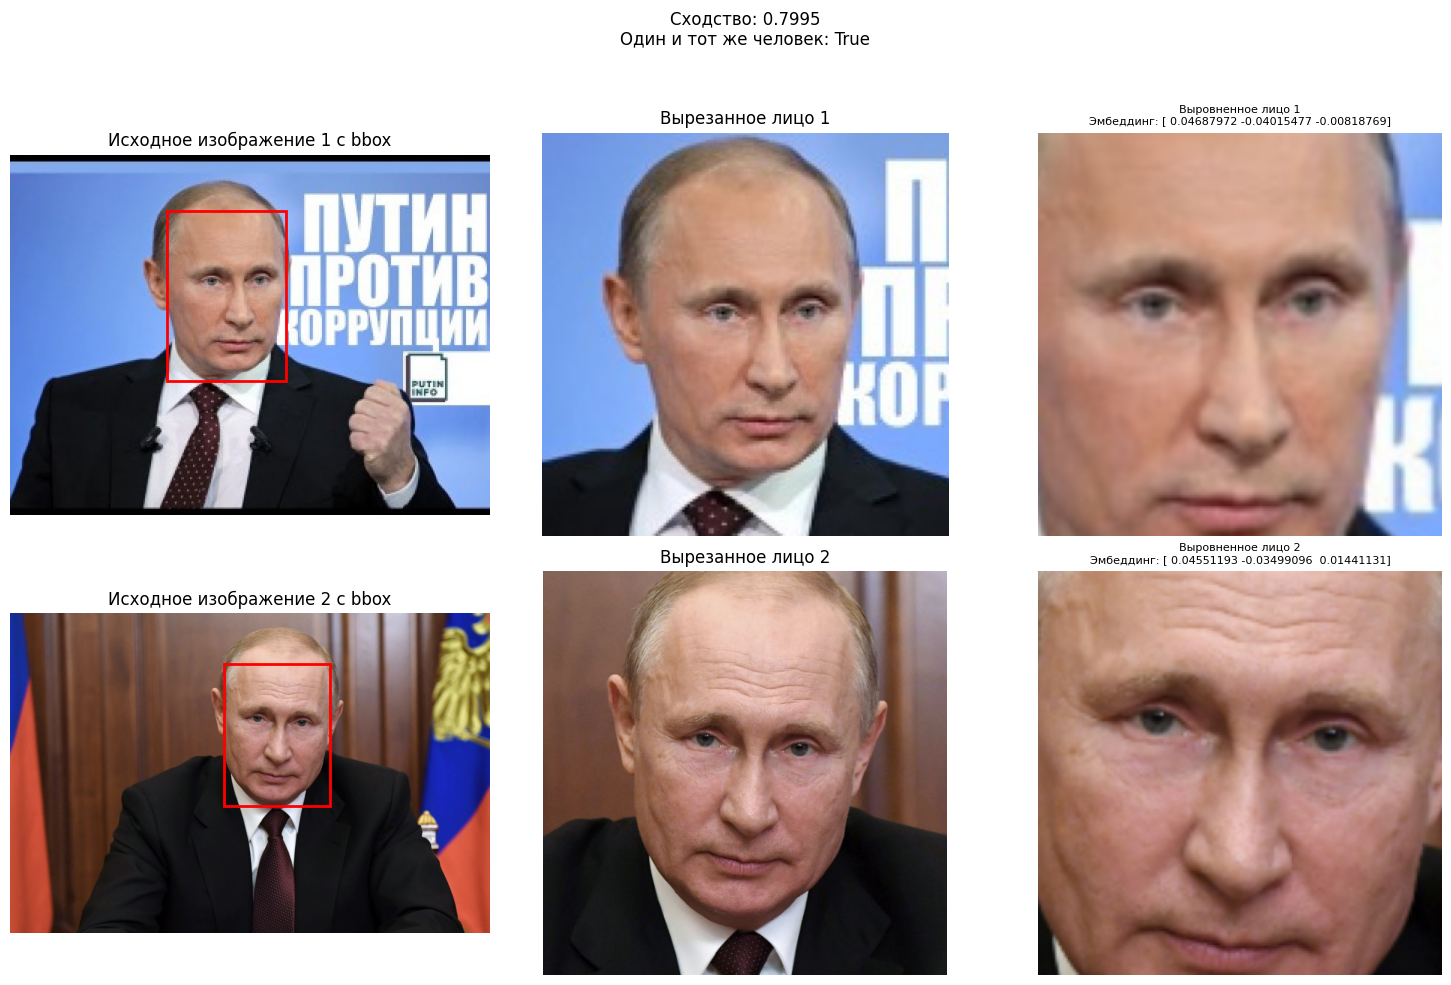

In [6]:
image_path1 = 'D:\\dlsPart2\\p1.jpg'
image_path2 = 'D:\\dlsPart2\\p2.jpg'


result = pipeline.process_and_compare(image_path1, image_path2)
if result:
    print(f"Один и тот же ли это человек?: {result['is_same_person']}")
    print(f"Сходство: {result['similarity_score']:.4f}")

visualize_results(result)